# Mallas 3D y normales

In [1]:
# Importamos las bibliotecas necesarias

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
%matplotlib notebook
%matplotlib inline

Vamos a explorar el concepto de mallas 3D. En el mundo de los gráficos por ordenador se pueden establecer cuatro tipo de modelos para representar información 3D:

1. Nubes de puntos: Toda la información visual se representan con puntos (típico modelo obtenido del escaneo 3D, por ejemplo).
2. Mallas 3D: Representan las superficies de los objetos, pero no hay interior (típico modelo usado en videojuegos, por ejemplo).
3. Sólidos: Representan la superficie y el interior de los objetos con un material uniforme (típico en el diseño 3D e industrial).
4. Volúmenes: Representan tanto el interior heterogéneo como el exterior (típico de modelos 3D en medicina, por ejemplo obtenidos con Resonancia Magnética).

En este caso vamos a centrarnos en las Mallas 3D.

Una malla 3D se puede definir con tres conjuntos:

1. Vértices: $V = \{ p_i \in \mathbb{E}^3, \ \  1 \leq i \leq n \}$
2. Aristas: $E = \{ (i,j)\in \mathbb{V} \times \mathbb{V} \}$
3. Caras: $F = \{(i_1,i_2, \ldots, i_n), \ \  i_k \in \mathbb{V}, \ \  (i_k, i_{k+1}) \in E\}$

Gráficamente se puede ver que como mínimo necesitaríamos una lista de vértices, otra de aristas, y otra con las caras. Las caras podrían ser triángulos (aunque luego se podrían componer en poliedros más complejos), hasta montar la superficie final que conformaría el modelo.

![Esquema de una malla 3D](https://upload.wikimedia.org/wikipedia/commons/6/6d/Mesh_overview.svg "Esquema de una malla 3D")

## Vértices

La lista de vértices es simple de crear, basta con un array de coordenadas homogéneas:

In [2]:
vertices = np.array([
    [1, 1, 1, 1],
    [1, 0, 0, 1],
    [0, 1, 0, 1]
])

Como esta forma de definir los vértices es tedioso (añadir siempre la cuarta dimensión) vamos a crear una función que pase coordenadas 3D a coordenadas homogéneas:

In [3]:
def homogeneas(array):
  """
  Convierte coordenadas 3D a coordenadas homogéneas
  """
  ext = np.ones(shape=(array.shape[0], 1))
  return np.column_stack((array, ext))

In [4]:
vertices = np.array([
    [1, 1, 1],
    [1, 0, 0],
    [0, 1, 0]
])

homogeneas(vertices)

array([[1., 1., 1., 1.],
       [1., 0., 0., 1.],
       [0., 1., 0., 1.]])

En realidad ahora mismo no nos preocuparemos de las coordenadas homogéneas, ya que no vamos a realizar transformaciones geométricas.

Vamos a visualizar los vértices, para ello crearemos primero una función para preparar el entorno 3D:

In [5]:
def crearEspacio3D(title='Visualizador 3D', rango=[-3, 3, -3, 3, -3, 3]):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(color='gray', linestyle='--', linewidth=0.25)
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    ax.set_title(title)
    ax.set_xlim(rango[0], rango[1])
    ax.set_ylim(rango[2], rango[3])
    ax.set_zlim(rango[4], rango[5])
    ax.plot([0, 0], [0, 0], [rango[0], rango[1]], color='green', linewidth=0.5)
    ax.plot([0, 0], [rango[0], rango[1]], [0, 0], color='blue', linewidth=0.5)
    ax.plot([rango[0], rango[1]], [0, 0], [0, 0], color='red', linewidth=0.5)
    ax.grid(True)
    return fig,ax

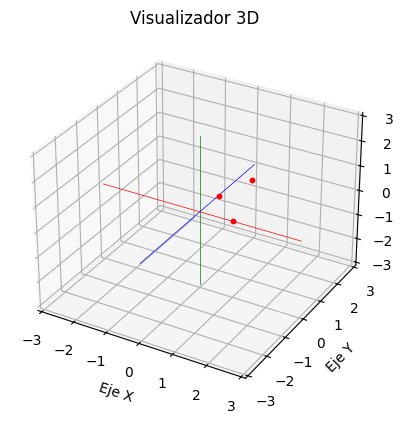

In [6]:
fig,ax = crearEspacio3D()
for v in vertices:
    ax.scatter(v[0], v[1], v[2], color='red', s=10)
plt.show()

## Aristas

Una primera solución inicial para almacenar las aristas (*edges*) sería almacenar las coordenadas de cada vértice primero, pero esto crearía duplicados:

```python
vertices = np.array([
    [1, 1, 1],
    [1, 0, 0],
    [0, 1, 0]
])
```

```python
edges = np.array([
    [ [1, 1, 1], [1, 0, 0] ],
    [ [1, 0, 0], [0, 1, 0] ],
    [ [0, 1, 0], [1, 1, 1] ]
])
```

¿Lo ves? Tenemos repetida la información y eso no es bueno. Es más inteligente indexar los elementos. Observa:

In [7]:
indice = 0
for v in vertices:
    print(indice, "→", v)
    indice += 1

0 → [1 1 1]
1 → [1 0 0]
2 → [0 1 0]


Cada vértice tiene un número asociado (su posición en el array), así que podemos crear las aristas simplemente indexándolas:

In [8]:
edges = np.array([
    [0, 1],
    [1, 2],
    [2, 0]
])

Es decir, la primera arista unirá los vértices de las posiciones 0 y 1 en el array de vértices, la segunda unirá los vértices 1 y 2 del array de vértices, y finalmente se unirán los vértices de las posiciones 2 y 0.

Vamos a dibujarlo:

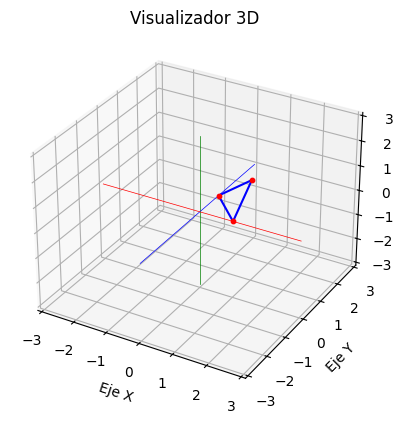

In [9]:
fig, ax = crearEspacio3D()
for v in vertices:
    ax.scatter(v[0], v[1], v[2], color='red', s=10)
for e in edges:
    indice1, indice2 = e
    v1 = vertices[indice1]
    v2 = vertices[indice2]
    ax.plot([v1[0], v2[0]], 
            [v1[1], v2[1]],
            [v1[2], v2[2]], color='blue')
plt.show()

## Caras

Vamos ahora con las caras (*faces*). La cara se puede definir como una secuencia de vértices (nosotros usaremos 3 vértices, porque vamos a simplificar nuestro modelo para que solamente utilice triángulos).

Como hemos visto, una opción sería definirlo con valores reales, lo cual duplicaría información y nos podría llevar a errores. La otra, mucho más eficiente, es usar los índices:

In [10]:
faces = np.array([
    [0, 1, 2]
])

Vamos a dibujar la cara:

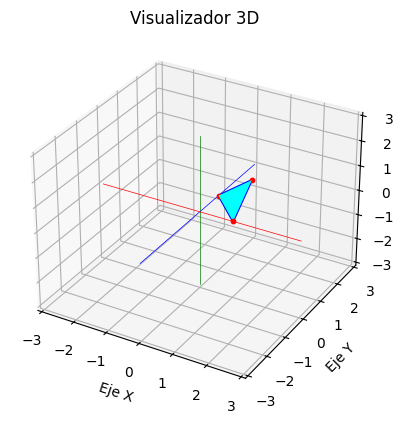

In [11]:
fig, ax = crearEspacio3D()
x = vertices[:, 0]
y = vertices[:, 1]
z = vertices[:, 2]
ax.plot_trisurf(x, y, z, triangles=faces, facecolor='aqua')

for v in vertices:
    ax.scatter(v[0], v[1], v[2], color='red', s=10)
for e in edges:
    indice1, indice2 = e
    v1 = vertices[indice1]
    v2 = vertices[indice2]
    ax.plot([v1[0], v2[0]], 
            [v1[1], v2[1]],
            [v1[2], v2[2]], color='blue')
plt.show()

En realidad habrás notado, que con la estructura de cara, no tiene sentido mantener la estructura de lados, ya que estos lados salen del propio orden definido de la cara. Si no lo ves, examina este código:

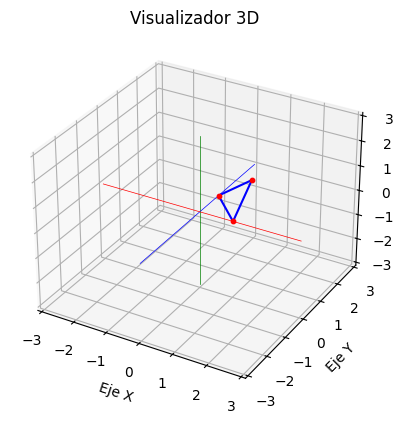

In [12]:
fig, ax = crearEspacio3D()
x = vertices[:, 0]
y = vertices[:, 1]
z = vertices[:, 2]

for v in vertices:
    ax.scatter(v[0], v[1], v[2], color='red', s=10)

for face in faces:
    edge1 = [face[0], face[1]]
    edge2 = [face[1], face[2]]
    edge3 = [face[2], face[0]]
    edges = [edge1, edge2, edge3]
    
    for edge in edges:
        indice1, indice2 = edge
        v1 = vertices[indice1]
        v2 = vertices[indice2]
        ax.plot([v1[0], v2[0]], 
                [v1[1], v2[1]],
                [v1[2], v2[2]], color='blue')
plt.show()

## Orientación de las caras

Las caras tienen además una orientación. Piensa por un momento, ¿qué grosor tiene una cara?

La respuesta es: no tiene grosor. Eso significa que no representa un objeto real. Para que tengamos un objeto, los triángulos deben crear una superficie cerrada (**sin agujeros**). Esto implica que tenemos que saber que parte de las caras son interiores (invisibles) y que parte son exteriores (visibles).

Si quieres un ejemplo práctico, puedes activar la opción de colorear las caras traseras en [Blender](https://blender.org).

![Cara trasera en rojo](https://i.stack.imgur.com/e0Mnt.png "Cara trasera en rojo")

## Normales de cara

Este concepto de **orientación de la cara** está intimamente ligado a la **normal de la cara**. La normal es el vector perpendicular a la cara, y es muy fácil calcularlo a partir de dos lados.

Vamos a ver un ejemplo en nuestro modelo. Para ello, necesitamos obtener dos vectores $\mathbf{e_1}$ y $\mathbf{e_2}$ a partir de la resta de los tres vértices. Multiplicando estos dos vectores entre sí (multiplicación vectorial, recuerda), podemos obtener la normal $\mathbf{n}$ (en azul) que deberá estar normalizada (ya que es una dirección).

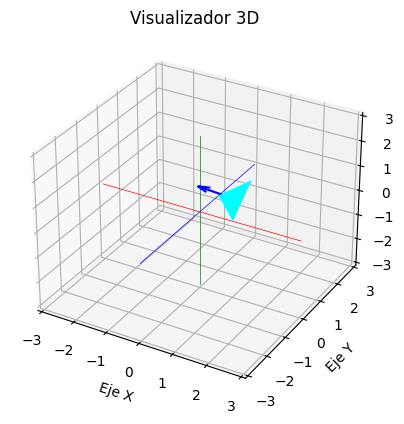

In [13]:
fig, ax = crearEspacio3D()
ax.plot_trisurf(x, y, z, triangles=faces, facecolor='aqua')

for face in faces:
    v0 = vertices[face[0]]
    v1 = vertices[face[1]]
    v2 = vertices[face[2]]
    
    # Los dos vectores
    e1 = v2 - v0
    e2 = v1 - v0
    n = np.cross(e1,e2)
    n = n / np.linalg.norm(e2)
    
    # punto medio del triángulo
    p = (v0 + v1 + v2) / 3

    # la normal está en azul
    ax.quiver(p[0], p[1], p[2], n[0], n[1], n[2], color='blue')
    # la dirección contraria en rojo
    # ax.quiver(p[0], p[1], p[2], -n[0], -n[1], -n[2], color='red')
plt.show()

Esta normal afectará a todos los algoritmos de visualización en el futuro. Desde el recorte de caras traseras (*back face culling*), hasta la iluminación de las fuentes de luz y el cálculo de las físicas del entorno.

Este tipo de normales se llaman **normales por cara**, y producen que las figuras se vean facetadas:
![Smooth vs Flat](https://i.ytimg.com/vi/cX2JHpbi6_g/maxresdefault.jpg "Smooth vs Flat")

Pero las normales se pueden calcular:

1. Por vértices.
2. Por fragmentos.

Una forma sencilla para calcular las normales por vértice es usar las normales de las caras que toca dicho vértice. Básicamente se suman todas las normales de cara adyacentes y se normaliza el resultado:

$\vec{N}_v= \| \sum_n \vec N_i \|$, siendo $n$ el número de caras adjuntas y $\vec N_0, \vec N_1,\ldots \vec N_{n-1}$ las normales de cada cara adjacente al vértice $v$.

Esto se puede hacer usando estructuras de [Arista Alada](https://es.wikipedia.org/wiki/Lista_de_aristas_doblemente_conectadas), o utilizando otras estructuras como en [Marching Cubes](https://en.wikipedia.org/wiki/Marching_cubes).


## Ejemplo: Normales en una esfera

Creamos una función que construya los vértices de una esfera:

In [14]:
def esfera(resolucion, radio):
    """
    Genera una esfera utilizando dos círculos en dos ejes.
    
    Args:
        resolucion (int): Número de divisiones en la esfera (mayor resolución = más vértices).
        radio (float): Radio de la esfera.
    
    Returns:
        np.array: Matriz 3D con los vértices de la esfera.
    """
    phi = np.linspace(0, 2 * np.pi, resolucion)  # Ángulo azimutal (0 a 2pi)
    theta = np.linspace(0, np.pi, resolucion)  # Ángulo polar (0 a pi)
    phi, theta = np.meshgrid(phi, theta)  # Crea una malla de puntos
    
    # Coordenadas cartesianas de los vértices
    x = radio * np.sin(theta) * np.cos(phi)
    y = radio * np.sin(theta) * np.sin(phi)
    z = radio * np.cos(theta)
    
    # Devuelve los vértices como un array 3D
    return [x.flatten(), y.flatten(), z.flatten()]

In [15]:
x, y, z = esfera(6, 1)

Tenemos los vértices, ahora necesitamos las caras:

In [16]:
def triangulos_esfera(resolucion):
    # Índices de los vértices para los triángulos
    indices = []
    for i in range(resolucion-1):
        for j in range(resolucion-1):
            v1 = i * resolucion + j
            v2 = i * resolucion + (j + 1) % resolucion
            v3 = ((i + 1) % resolucion) * resolucion + j
            v4 = ((i + 1) % resolucion) * resolucion + (j + 1) % resolucion
            indices.append(np.array([v3, v2, v1], dtype=int))
            indices.append(np.array([v3, v4, v2], dtype=int))

    return np.array(indices)

In [17]:
faces = triangulos_esfera(6)
print(faces.shape, x.shape, y.shape, z.shape)

(50, 3) (36,) (36,) (36,)


Representamos la esfera:

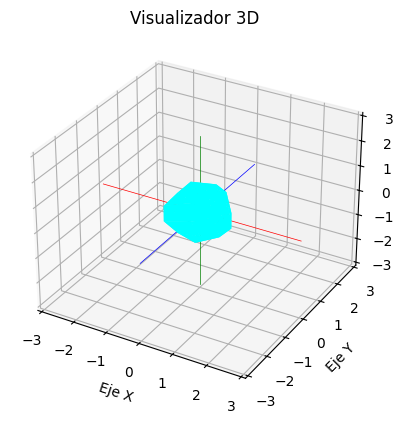

In [18]:
fig, ax = crearEspacio3D()

ax.plot_trisurf(x, y, z, triangles=faces, facecolor='aqua')
plt.show()

Calculemos las normales por cara:

In [19]:
def normales_por_cara(vertices, caras):
    """
    Calcula las normales por cara para un modelo 3D.

    Args:
        vertices (np.array): Array 2D con los vértices (x, y, z).
        caras (np.array): Array 2D con los índices de las caras (tripletes de vértices).

    Returns:
        np.array: Array 2D con las normales por cara.
    """
    normales = []
    puntos_medios = []
    for cara in caras:
        v0, v1, v2 = cara
        # Calcula los vectores de los lados del triángulo
        lado1 = vertices[v1] - vertices[v0]
        lado2 = vertices[v2] - vertices[v0]
        # Calcula la normal por cara como el producto cruz de los lados
        normal_cara = np.cross(lado1, lado2)
        # Normaliza la normal por cara (opcional)
        normal_cara /= np.linalg.norm(normal_cara)
        normales.append(normal_cara)
        # Calcula la posición media de la cara
        puntos_medios.append(np.array((vertices[v0] + vertices[v1] + vertices[v2])/3))

    return np.array(puntos_medios), np.array(normales)

In [20]:
vertices = np.concatenate((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis]), axis=1)
print(faces.shape, vertices.shape)
puntos_medios, normales = normales_por_cara(vertices, faces)

print(puntos_medios.shape, normales.shape)

(50, 3) (36, 3)
(50, 3) (50, 3)


/tmp/ipykernel_21515/1050622740.py:22: RuntimeWarning: invalid value encountered in divide
  normal_cara /= np.linalg.norm(normal_cara)


Dibujemos las normales por cara:

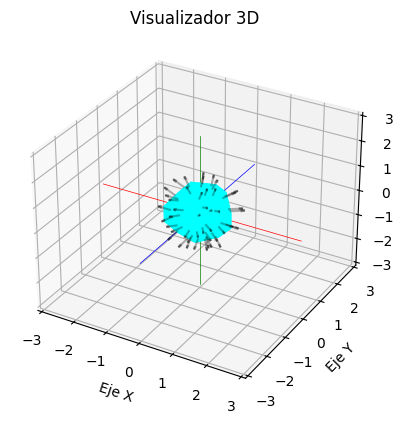

In [21]:
fig, ax = crearEspacio3D()

ax.plot_trisurf(x, y, z, triangles=faces, facecolor='aqua')
ax.quiver(puntos_medios[:, 0], puntos_medios[:, 1], puntos_medios[:, 2],
          normales[:, 0], normales[:, 1], normales[:, 2],
          length=0.4, normalize=True, color='black', alpha=0.3)
plt.show()

------

Autor: **Germán Arroyo**

[Creative Commons BY 4.0](https://creativecommons.org/licenses/by/4.0/) ![](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by.svg)